#### Imports

In [1851]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [1852]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size
132,3758948418,Data Analyst,The Intersect Group,TN,410000.0,Híbrido,Jornada completa,Director,L
131,3758917866,Data Analyst,DISYS,FL,410000.0,Híbrido,Jornada completa,Director,L
36,3719230993,Machine Learning Engineer,Rokt,NY,350000.0,Híbrido,Jornada completa,Intermedio,L
377,3771328759,Data Engineer,REALLY,TX,76800.0,Presencial,Jornada completa,Prácticas,M
503,3775831666,Machine Learning Engineer,Actalent,MD,346850.0,En remoto,Jornada completa,Sin experiencia,L


In [1853]:
linkedin.shape

(562, 9)

Rename salary_range column to salary

In [1854]:
linkedin.rename(columns={'salary_range': 'salary'}, inplace=True)

First we need to see which columns have null values.

In [1855]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
salary              71
remote_ratio        17
employment_type      0
experience_level     3
company_size         6
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [1856]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(71, 9)

In [1857]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(491, 9)

Let's save this dataframe for sql queries.

In [1858]:
linkedin.to_csv('../data/linkedin_salaries_sql.csv', index=False)

Let's check again null values in order to delete those rows.

In [1859]:
linkedin.isna().sum()

job_id              0
job_title           0
company_name        0
company_state       0
salary              0
remote_ratio        2
employment_type     0
experience_level    3
company_size        5
dtype: int64

In [1860]:
linkedin = linkedin[linkedin[['remote_ratio']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['experience_level']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['company_size']].notna().any(axis=1)]
linkedin.shape

(482, 9)

##### Function to clean both datasets

In [1861]:
def prepare_dataset(dframe):
    df = dframe.copy()
    # df = df.drop(columns=['company_name', 'company_state'])
    df = df[df[['remote_ratio']].notna().any(axis=1)]
    df = df[df[['experience_level']].notna().any(axis=1)]
    df = df[df[['company_size']].notna().any(axis=1)]
    return df

In [1862]:
prepared_to_predict = prepare_dataset(to_predict)
prepared_to_predict.shape

(55, 9)

    Column 'job_title'

Classificating the job_title category with numbers.

In [1863]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,262530.636364
9,Research Engineer,248625.000000
8,Machine Learning Engineer,247789.444444
1,BI Analyst,236500.000000
6,Data Scientist,189190.675926
5,Data Engineer,185200.381356
4,Data Analyst,154874.258333
3,Business Analyst,138750.000000
0,AI Engineer,134504.166667
2,BI Engineer,110000.000000


    Column 'remote_ratio'

In [1864]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     197
Híbrido       160
Presencial    125
Name: count, dtype: int64

    Column 'employment_type'

In [1865]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     353
Contrato por obra     98
Prácticas             31
Name: count, dtype: int64

    Column 'experience_level'

In [1866]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 239
Sin experiencia            125
Algo de responsabilidad     54
Prácticas                   46
Director                    16
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [1867]:
linkedin['company_size'].value_counts()

company_size
L    304
M    159
S     19
Name: count, dtype: int64

#### Cleaning function

In [1868]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    oneonehotencoder = ps.OneHotEncoder()
    df[['Jornada completa', 'Contrato por obra', 'Prácticas']] = oneonehotencoder.fit_transform(df["employment_type"].values.reshape(-1, 1)).toarray()

    # 4. experience_level
    experience_categories = {
        'Director': 3,
        'Ejecutivo': 3,
        'Algo de responsabilidad': 2,
        'Intermedio': 2,
        'Sin experiencia': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    return df

In [1869]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary,remote_ratio,employment_type,experience_level,company_size,Jornada completa,Contrato por obra,Prácticas,L,M,S
267,3766873021,9,Path Robotics,OH,425000.0,0,Jornada completa,3,L,0.0,1.0,0.0,1.0,0.0,0.0
415,3772976776,5,HP,TX,57600.0,100,Jornada completa,2,L,0.0,1.0,0.0,1.0,0.0,0.0
27,3697918396,6,TikTok,CA,292600.0,50,Jornada completa,2,L,0.0,1.0,0.0,1.0,0.0,0.0
540,3776788618,5,Dice,WA,230000.0,100,Jornada completa,2,L,0.0,1.0,0.0,1.0,0.0,0.0
304,3768734796,5,SQUAD Techlab,CA,110000.0,100,Contrato por obra,2,S,1.0,0.0,0.0,0.0,0.0,1.0


In [1870]:
to_predict.sample()
to_predict['company_size'].unique()

array(['L', 'M', 'S', nan], dtype=object)

In [1871]:
prepared_to_predict = categorizing_dataset(prepared_to_predict)
prepared_to_predict.sample()

,job_id,job_title,company_name,company_state,salary,remote_ratio,employment_type,experience_level,company_size,Jornada completa,Contrato por obra,Prácticas,L,M,S
255,3766662568,5,Accroid Inc,MN,NaN,50,Media jornada,0,M,0.0,1.0,0.0,0.0,1.0,0.0


In [1872]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

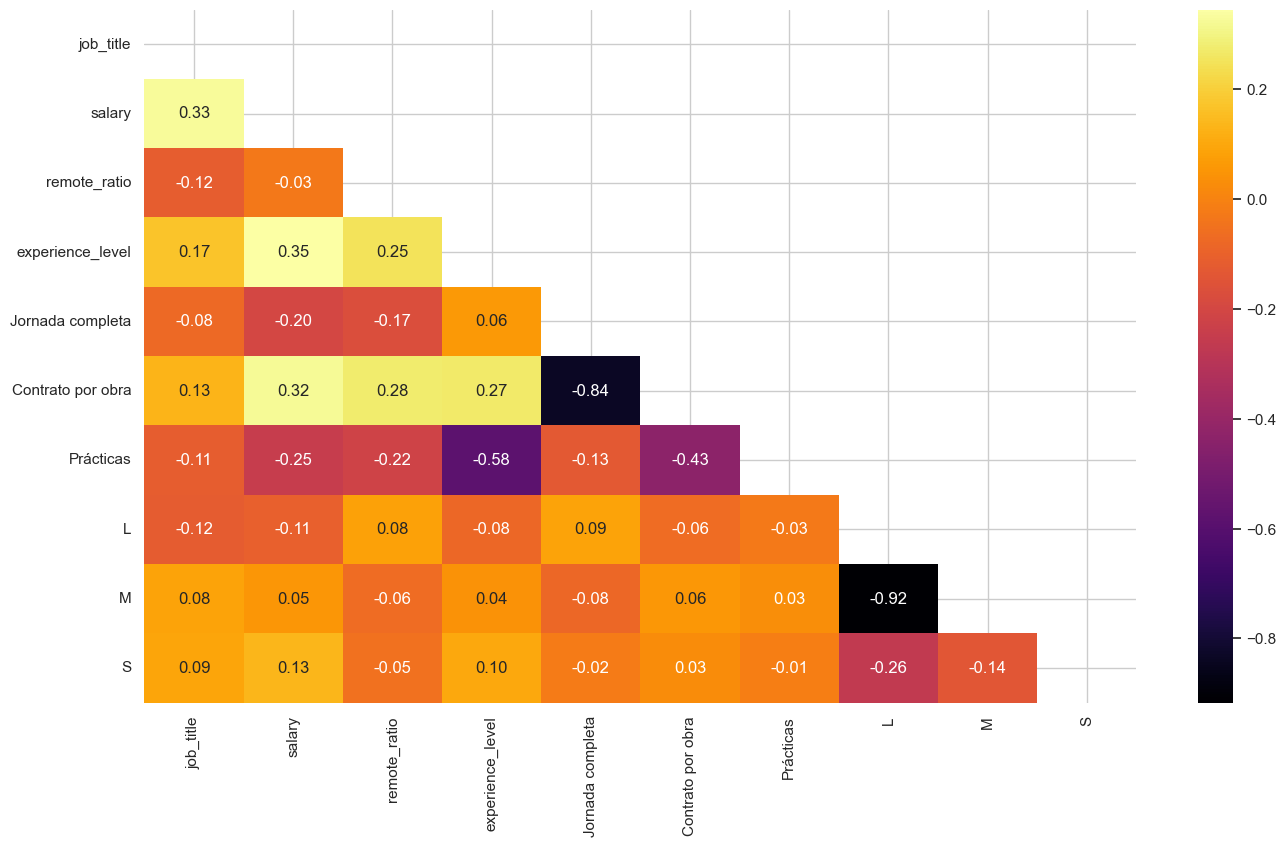

In [1873]:
corr = prepared_linkedin.select_dtypes(exclude=['object']).drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [1874]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier

In [1875]:
X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    LinearRegression

In [1876]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [1877]:
y_pred = regressor.predict(X_test)

In [1878]:
metrics.r2_score(y_test, y_pred)

0.23762887610214378

    DecisionTreeRegressor

In [1879]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [1880]:
y_pred = regressor.predict(X_test)

In [1881]:
metrics.r2_score(y_test, y_pred)

0.19483250132992336

    KNeighborsRegressor

In [1882]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [1883]:
y_pred = regressor.predict(X_test)

In [1884]:
metrics.r2_score(y_test, y_pred)

0.48058053380784627

    GradientBoostingRegressor

In [1885]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [1886]:
y_pred = regressor.predict(X_test)

In [1887]:
metrics.r2_score(y_test, y_pred)

0.5498743929286339

    RandomForestRegressor

In [1888]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [1889]:
y_pred = regressor.predict(X_test)

In [1898]:
r2 = metrics.r2_score(y_test, y_pred)
r2

0.5193645247185976

In [1891]:
import pickle

# model_file = f'../models/RandomForestRegressor_r2_{r2}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [1892]:
model_file = '../models/RandomForestRegressor_r2_0.8042839793495793.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.934214651861346

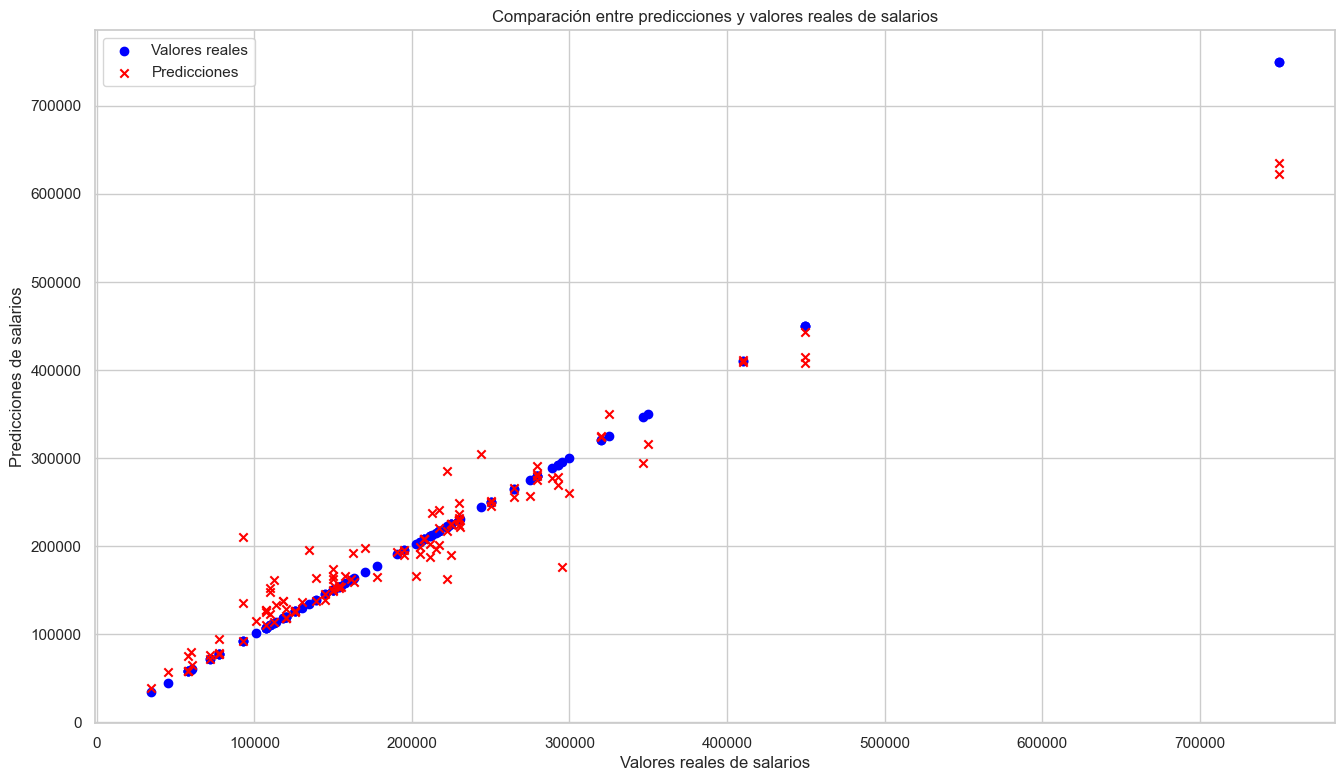

In [1906]:
plt.scatter(y_test, y_test, color='blue', label='Valores reales', marker='o')

# Diferenciar las predicciones de salarios con otro color y marcador
plt.scatter(y_test, pred, color='red', label='Predicciones', marker='x')

plt.xlabel('Valores reales de salarios')
plt.ylabel('Predicciones de salarios')
plt.title('Comparación entre predicciones y valores reales de salarios')
plt.legend()
plt.show()

#### TESTS with X_test

In [1893]:
X_test_copy = X_test.copy()
X_test_copy['salary'] = y_pred
X_test_copy['salary_real'] = y_test
X_test_copy.sample(5)

,job_id,job_title,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S,salary,salary_real
337,3770133308,4,0,0,0.0,0.0,1.0,1.0,0.0,0.0,72432.00,72000.0
6,3605390007,9,50,1,0.0,1.0,0.0,1.0,0.0,0.0,445308.00,449600.0
402,3772877944,4,100,2,0.0,1.0,0.0,1.0,0.0,0.0,57600.00,57600.0
353,3770183600,5,50,1,1.0,0.0,0.0,1.0,0.0,0.0,65545.98,34560.0
323,3769541895,6,100,2,1.0,0.0,0.0,1.0,0.0,0.0,216625.96,222000.0


#### Prediction for those with null salary

In [1894]:
prediction = regressor.predict(prepared_to_predict.select_dtypes(exclude=['object']).drop(columns=['salary']))

In [1895]:
to_predict.sample()

,job_id,job_title,company_name,company_state,salary,remote_ratio,employment_type,experience_level,company_size
35,3713995239,Data Analyst,Delta Air Lines,GA,NaN,Presencial,Prácticas,Intermedio,L


In [1896]:
prepared_to_predict['salary'] = prediction # Adding the predicted price
prepared_to_predict.sample(5)

,job_id,job_title,company_name,company_state,salary,remote_ratio,employment_type,experience_level,company_size,Jornada completa,Contrato por obra,Prácticas,L,M,S
260,3766685481,5,DeRisk Technologies,OR,74566.20,50,Media jornada,0,L,0.0,1.0,0.0,1.0,0.0,0.0
553,3776948509,6,HustleWing - Side hustles for professionals,Estados Unidos,205432.00,100,Media jornada,2,S,0.0,1.0,0.0,0.0,0.0,1.0
92,3753408170,10,NVIDIA,CA,120610.92,50,Prácticas,0,L,0.0,0.0,1.0,1.0,0.0,0.0
93,3754419732,6,AMISEQ,CA,117494.40,50,Prácticas,0,M,0.0,0.0,1.0,0.0,1.0,0.0
98,3755116125,6,INSIGHT2PROFIT,IL,111694.20,50,Prácticas,0,L,0.0,0.0,1.0,1.0,0.0,0.0


In [1897]:
prepared_to_predict.to_csv('../data/linkedin_predicted_sql.csv', index=False)